# Notebook with figures for this work

In [1]:
using Pkg
# cd("/g/data/e14/jb2381/CabbelingExperiments")
# Pkg.activate(@__DIR__)
Pkg.activate(joinpath(@__DIR__, "../"))
using NCDatasets, CairoMakie, TwoLayerDirectNumericalShenanigans, StatsBase, Printf, GibbsSeaWater
using TwoLayerDirectNumericalShenanigans: tanh_initial_condition

  Activating project at `~/Documents/PhD data and code/CabbelingExperiments`
┌ Info: Oceananigans will use 8 threads
└ @ Oceananigans /Users/Joey/.julia/packages/Oceananigans/aI5AQ/src/Oceananigans.jl:270


## Change in thermal expansion and haline contraction coefficients

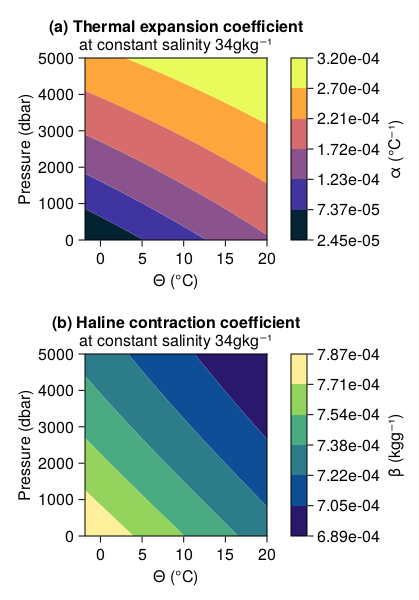

In [6]:
Sₐ = 34
N = 1000
p = range(0, 5000, length = 1000)
Θ_freezing = gsw_ct_freezing(Sₐ, 0, 0)
Θ = range(Θ_freezing, 20, length = 1000)
Θ_grid = ones(N) .* Θ'
p_grid = p .* ones(N)'
α = gsw_alpha.(Sₐ, Θ_grid, p_grid)
β = gsw_beta.(Sₐ, Θ_grid, p_grid)
fig = Figure(size = (500, 800))
levels = 7
## Thermal expansion coefficient
ax = Axis(fig[1, 1], 
            title = "(a) Thermal expansion coefficient",
            subtitle = "at constant salinity $(Sₐ)gkg⁻¹",
            xlabel = "Θ (°C)",
            ylabel = "Pressure (dbar)",
            aspect = 1)
α_levels = range(extrema(α)..., length = levels)
cf = contourf!(ax, Θ, p, α; colormap = :thermal, levels = α_levels)
tightlimits!(ax)
Colorbar(fig[1, 2], cf, label = "α (°C⁻¹)", ticks = α_levels, tickformat = "{:.2e}")
## Haline contraction coefficient
ax2 = Axis(fig[2, 1], 
            title = "(b) Haline contraction coefficient",
            subtitle = "at constant salinity $(Sₐ)gkg⁻¹",
            xlabel = "Θ (°C)",
            ylabel = "Pressure (dbar)",
            aspect = 1)
β_levels = range(extrema(β)..., length = levels)
cf = contourf!(ax2, Θ, p, β; colormap = :haline, levels = β_levels)
tightlimits!(ax2)
Colorbar(fig[2, 2], cf, label = "β (kgg⁻¹)", ticks = β_levels, tickformat = "{:.2e}")
## Adjust layout
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)
fig
# save("alpha_and_beta.png", fig)

## Mixing schematic

In [34]:
S_star, Θ_star = 34.7, 0.5
S₀ᵘ = 34.58
Θᵘ = -1.5
slope = (Θᵘ - Θ_star) / (S₀ᵘ - S_star)
S_mix = range(S₀ᵘ, S_star, step = 0.000001)
Θ_mix = @. Θᵘ + (slope) * (S_mix - S₀ᵘ)
ρ_mix = gsw_rho.(S_mix, Θ_mix, 0)
max_rho, max_rho_idx = findmax(ρ_mix)
S_max, Θ_max = S_mix[max_rho_idx], Θ_mix[max_rho_idx]
Δρ_mix = max_rho - gsw_rho(S_star, Θ_star, 0)

N = 2000
S_range, Θ_range = range(34.52, 34.72, length = N), range(-2, 1, length = N)
S_grid, Θ_grid = ones(N) .* S_range', ones(N)' .* Θ_range
ρ = gsw_rho.(S_grid, Θ_grid, 0)
ρ_star = gsw_rho(S_star, Θ_star, 0)
ρ_s = gsw_rho(S₀ᵘ, Θᵘ, 0)
find_Θ = findfirst(Θ_range .> -1.5)
find_S = findfirst(ρ[find_Θ, :] .> ρ_star)
S_iso, Θ_iso = S_range[find_S], Θ_range[find_Θ]
gsw_rho(S_iso, Θ_iso, 0)
αₗ, βₗ = gsw_alpha(S_star, Θ_star, 0), gsw_beta(S_star, Θ_star, 0)
m_initial = βₗ / αₗ
Θ_linear_initial = @. Θ_star + m_initial * (S_range - S_star)
αₘ, βₘ = gsw_alpha(S_max, Θ_max, 0), gsw_beta(S_max, Θ_max, 0)
m = βₘ / αₘ
Θ_linear = @. Θ_max + m * (S_range - S_max)
fig = Figure(size = (500, 500), fontsize = 22)
ax = Axis(fig[1, 2];
          title = "(b) Cabbeling effect in S-Θ space",
          xlabel = "Absolute salinity",
          ylabel = "Conservative temperature",
          xticklabelsvisible = false,
          yticklabelsvisible = false,
          xgridvisible = false,
          xticksvisible = false,
          yticksvisible = false,
          ygridvisible = false,
          limits = (extrema(S_range), extrema(Θ_range)))
hidespines!(ax)
contour!(ax, S_range, Θ_range, ρ'; levels = [ρ_s, ρ_star], color = [:blue, :red], 
         linewidth = 0.8, labelsize = 18, label = "Isopycnals", linestyle = :dot)
scatter!(ax, [S_star], [Θ_star], color = :red, label = "Deep water mass")
scatter!(ax, [S₀ᵘ], [Θᵘ], color = :blue, label = "Shallow water mass")
# lines!(ax, S_range, Θ_linear_initial, color = :red, linestyle = :dot, label = "Tangent at deep water parcel")
lines!(ax, S_mix, Θ_mix, color = :purple, linestyle = :dash, label = "Mixed water")
arrows!(ax, [S_range[15]], [Θ_range[15]], [1], [0], lengthscale = 0.19)
arrows!(ax, [S_range[15]], [Θ_range[15]], [0], [1], lengthscale = 2.8)
axislegend(ax, position = :lt)

ax2 = Axis(fig[1, 1],
          title = "(a) Two layer profile",
          aspect = 1/2,
          ylabel = "z (m)",
          yticksvisible = false,
          yticklabelsvisible = false,
          ygridvisible = false)
hidexdecorations!(ax2)
hidespines!(ax2)
data2 = [vcat(fill(0, 4), 1, fill(2, 4)) vcat(fill(0, 4), 1, fill(2, 4))]
hm = heatmap!(ax2, 0:2, 0:10, data2'; colormap = [:red, :purple, :blue])
text!(ax2, 0.75, 6.5,  text = L"ρ^{-}", fontsize = 34)
text!(ax2, 0.75, 2.5,  text = L"ρ^{+}", fontsize = 34)
text!(ax2, 0.75, 4.8,  text = L"ρ_{\mathrm{mixed}}", fontsize = 34)
arrows!(ax2, [0.01], [10], [0], [-1], lengthscale = 9.8, linewidth = 2.5, arrowsize = 15)
colsize!(fig.layout, 1, Auto(0.5))
fig
#save("STfig_preso.png", fig)

CairoMakie.Screen{IMAGE}


## DNS possible states

In [11]:
S_star, Θ_star = 34.7, 0.5
S₀ᵘ = 34.58
Θᵘ = -1.5
slope = (Θᵘ - Θ_star) / (S₀ᵘ - S_star)
S_mix = range(S₀ᵘ, S_star, step = 0.000001)
Θ_mix = @. Θᵘ + (slope) * (S_mix - S₀ᵘ)
ρ_mix = gsw_rho.(S_mix, Θ_mix, 0)
max_rho, max_rho_idx = findmax(ρ_mix)
S_max, Θ_max = S_mix[max_rho_idx], Θ_mix[max_rho_idx]
Δρ_mix = max_rho - gsw_rho(S_star, Θ_star, 0)

N = 2000
S_range, Θ_range = range(34.52, 34.72, length = N), range(-2, 1, length = N)
S_grid, Θ_grid = ones(N) .* S_range', ones(N)' .* Θ_range
ρ = gsw_rho.(S_grid, Θ_grid, 0)
ρ_star = gsw_rho(S_star, Θ_star, 0)
ρ_s = gsw_rho(S₀ᵘ, Θᵘ, 0)
find_Θ = findfirst(Θ_range .> -1.5)
find_S = findfirst(ρ[find_Θ, :] .> ρ_star)
S_iso, Θ_iso = S_range[find_S], Θ_range[find_Θ]
gsw_rho(S_iso, Θ_iso, 0)
αₗ, βₗ = gsw_alpha(S_star, Θ_star, 0), gsw_beta(S_star, Θ_star, 0)
m_initial = βₗ / αₗ
Θ_linear_initial = @. Θ_star + m_initial * (S_range - S_star)
αₘ, βₘ = gsw_alpha(S_max, Θ_max, 0), gsw_beta(S_max, Θ_max, 0)
m = βₘ / αₘ
Θ_linear = @. Θ_max + m * (S_range - S_max)
fig = Figure(size = (1000, 800), fontsize = 22)
ax = Axis(fig[1, 1];
          title = "(a) Initial state",
          xlabel = "Absolute salinity",
          ylabel = "Conservative temperature",
          xticklabelsvisible = false,
          yticklabelsvisible = false,
          xticksvisible = false,
          yticksvisible = false,
          xgridvisible = false,
          ygridvisible = false,
          limits = (extrema(S_range), extrema(Θ_range)))
contour!(ax, S_range, Θ_range, ρ'; levels = [ρ_star], color = :red, linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal at deep water")
scatter!(ax, [S_star], [Θ_star], color = :red, label = "Initial deep water")
scatter!(ax, [S₀ᵘ], [Θᵘ], color = :blue, label = "Initial shallow water")
lines!(ax, S_mix, Θ_mix, color = (:purple, 0.5), linestyle = :dash, label = "Mixed water")
scatter!(ax, S_max, Θ_max, color = :purple, label = "Densest mixed water")
#axislegend(ax, position = :lt)

ax2 = Axis(fig[1, 2];
            title = "(b) Deep water at \nnew state",
            xlabel = "Absolute salinity",
            ylabel = "Conservative temperature",
            xticklabelsvisible = false,
            xticksvisible = false,
            xgridvisible = false,
            ygridvisible = false,
            yticksvisible = false,
            limits = (extrema(S_range), extrema(Θ_range)))
contour!(ax2, S_range, Θ_range, ρ'; levels = [max_rho], color = :purple, linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal")
contour!(ax2, S_range, Θ_range, ρ'; levels = [ρ_star], color = (:red, 0.3), linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal")
scatter!(ax2, [S₀ᵘ], [Θᵘ], color = :blue, label = "Shallow water")
scatter!(ax2, [S_star], [Θ_star], color = (:red, 0.3), label = "Initial deep water")
lines!(ax2, [S₀ᵘ, S_max], [Θᵘ, Θ_max], color = (:purple, 0.5), linestyle = :dash, label = "Mixed water")
scatter!(ax2, S_max, Θ_max, color = :purple, label = "New deep water")
hideydecorations!(ax2, grid = false)

ax3 = Axis(fig[1, 3];
            title = "(c) Shallow water at \nnew state",
            xlabel = "Absolute salinity",
            ylabel = "Conservative temperature",
            xticklabelsvisible = false,
            xticksvisible = false,
            xgridvisible = false,
            ygridvisible = false,
            yticksvisible = false,
            limits = (extrema(S_range), extrema(Θ_range)))
contour!(ax3, S_range, Θ_range, ρ'; levels = [ρ_star], color = :red, linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal")
scatter!(ax3, [S_star], [Θ_star], color = :red, label = "Deep water")
lines!(ax3, [S_star, S_max], [Θ_star, Θ_max], color = (:purple, 0.5), linestyle = :dash, label = "Mixed water")
scatter!(ax3, S_max, Θ_max, color = :purple, label = "New deep water water")
scatter!(ax3, [S₀ᵘ], [Θᵘ], color = (:blue, 0.3), label = "Shallow water")
hideydecorations!(ax3, grid = false)

linkyaxes!(ax, ax2, ax3)

Legend(fig[2, :], ax, orientation = :horizontal, nbanks = 3)
fig
#save("new_state_fig.png", fig)

CairoMakie.Screen{IMAGE}


## Mixing and energetics

In [41]:
Nz = 200
z = range(-10, 0, length = 2*Nz)

Sˡ, Θˡ = fill(34.7, Nz), fill(0.5, Nz)
Sᵘ, Θᵘ = fill(34.58, Nz), fill(-1.5, Nz)
S, Θ = vcat(Sˡ, Sᵘ), vcat(Θˡ, Θᵘ)
σ₀ = gsw_sigma0.(S, Θ)

Θ_mix = (Θᵘ[1] + Θˡ[1]) / 2
S_mix = (Sᵘ[1] + Sˡ[1]) / 2
mixing_interface = 198:203
S[mixing_interface] = fill(S_mix, length(mixing_interface))
Θ[mixing_interface] = fill(Θ_mix, length(mixing_interface))
σ₀_mix =  gsw_sigma0.(S, Θ)

fig = Figure(size = (1000, 500))
ax1 = Axis(fig[1, 1],
            title = "(a) Density profile",
            xlabel = "ρ",
            xgridvisible = false,
            xticksvisible = false,
            xticklabelsvisible = false,
            ylabel = "z",
            ygridvisible = false,
            yticksvisible = false,
            yticklabelsvisible = false)
lines!(ax1, σ₀, z, label = "Before mixing")
lines!(ax1, σ₀_mix, z, label = "After mixing", linestyle = :dash)
axislegend(ax1)

ax2 = Axis(fig[1, 2],
            title = "(b) Reference density profile",
            xlabel = "ρ",
            xgridvisible = false,
            xticksvisible = false,
            xticklabelsvisible = false,
            ygridvisible = false,
            yticksvisible = false,
            yticklabelsvisible = false)
lines!(ax2, sort(σ₀, rev = true), z, label = "Before mixing")
lines!(ax2, sort(σ₀_mix, rev = true), z, label = "After mixing", linestyle = :dash)
axislegend(ax2)
fig
#save("reference_density_profile.png", fig)

CairoMakie.Screen{IMAGE}
